In [1]:
import sys
import os
from openai import OpenAI

# Use current working directory and go one level up
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

# Now you can import your config
from config import api_key

client = OpenAI(api_key=api_key)

In [6]:
import openai
print(openai.__version__)

import chromadb
print(chromadb.__version__)

1.74.0
1.0.4


## Objectives
- Create and store the embeddings
    - Embed the reviews using a suitable text embeddingalgorithm and store them as list in the variable embeddings.
- Dimensionality reduction & visualization
    - Apply an appropriate dimensionality reduction technique to reduce the embeddings to a 2-dimensional numpy array and store this array in the variable embeddings_2d.
    - Then, use this variable to plot a 2D visual representation of the reviews.
  
- Feedback categorization
    - Use your embeddings to identify some reviews that discuss topics such as 'quality', 'fit', 'style', 'comfort', etc.
- Similarity search function
    - Write a function that outputs the closest 3 reviews to a given input review, enabling a more personalized customer service response.
    - Apply this function to the first review "Absolutely wonderful - silky and sexy and comfortable", and store the output as a list in the variable most_similar_reviews.

In [53]:
import pandas as pd

In [58]:
reviews = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
reviews.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### Create and store embeddings

Write a function that creates embeddings for the reviews. The funtion should return a list. Later on the results will be stored in a vector database together with some metadata.

In [59]:
reviews = reviews[:1000]
print(f"Dataset shape {reviews.shape}")
reviews = reviews.dropna(subset=["Review Text"])
review_texts = reviews['Review Text']
print(f"Dataset shape {reviews.shape}")

Dataset shape (1000, 11)
Dataset shape (958, 11)


In [61]:
# import open ai
from openai import OpenAI

# create openai client
client = OpenAI(api_key=api_key)

def create_embeddings(texts):
    response = client.embeddings.create(
    input=texts,
    model="text-embedding-3-small")

    response_dict = response.model_dump()
    return [record['embedding'] for record in response_dict['data']]

texts = reviews["Review Text"].values.tolist()
embeddings = create_embeddings(texts)

### 2d visualization using TSNE

Check embeddings shape (958, 2)


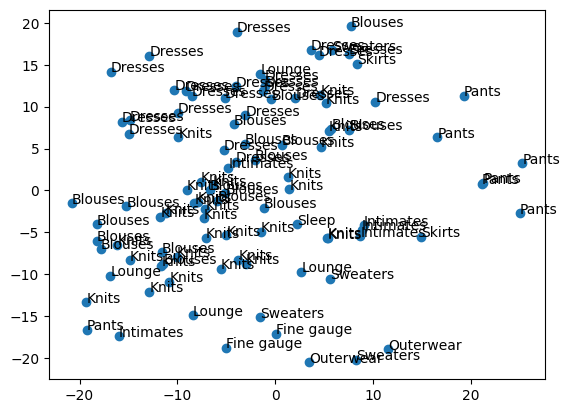

In [82]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(n_components=2, perplexity=50)

embeddings_2d = tsne.fit_transform(np.array(embeddings))

print(f"Check embeddings shape {embeddings_2d.shape}")

plt.scatter(embeddings_2d[:100,0], embeddings_2d[:100,1])

categories = reviews['Class Name'][:100].values.tolist()
#categories = reviews['Rating'][:100].values.tolist()

for i, category in enumerate(categories):
    plt.annotate(category, (embeddings_2d[i, 0], embeddings_2d[i, 1]))


In [76]:
reviews.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


 Use your embeddings to identify some reviews that discuss topics such as 'quality', 'fit', 'style', 'comfort', etc.

In [138]:
from scipy.spatial import distance
topic = "quality"
topic_embedding = create_embeddings(topic)[0]

def find_n_closest(query_embedding, search_embedding, n_closest=3):
    distances  = []
    for index, embedding in enumerate(search_embedding):
        dist = distance.cosine(np.array(query_embedding), np.array(embedding))
        distances.append({"index": index, "distance": dist})
    distances_sorted = sorted(distances, key= lambda x: x["distance"])
    return distances_sorted[:n_closest]
        

# get the review embeddings closest to the topic embedding
closest_result = find_n_closest(topic_embedding, embeddings)
# store the indices in a list 
closest_indices = [result['index'] for result in closest_result]

reviews.loc[closest_indices]

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
450,450,1077,30,Looks fine if you don't move your arms.,Three strikes and retailer is out for me! i am...,2,0,0,General,Dresses,Dresses
528,528,984,31,Easy jacket,Slouchy relaxed fit. well sewn together and ha...,3,1,0,General,Jackets,Jackets
586,586,1094,25,Love this dress,"I am 5'3"" 130 and curvy and this dress fit me ...",4,1,0,General,Dresses,Dresses
